In [3]:
# import packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
import matplotlib.pyplot as plt

In [4]:
seed = 2724

### Import data

In [6]:
DF_PATH = "mod04_data/sample.csv"
df = pd.read_csv(DF_PATH)

### Separate data by independent (X) and dependent (y) variables

In [7]:
X = df[["income", "education_years", "zipcode_score"]]
y = df["target"]

### Split the data into a _training_ set (to build a model) and _test_ set (to validate a model)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed
)

### Build a model on the training set

In [9]:
model = RandomForestRegressor(
    n_estimators=200,
    random_state=seed
)
model.fit(X_train, y_train)

,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Use SHAP to explain the model on test data

In [10]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

 99%|===================| 1491/1500 [02:16<00:00]        

This will allow us to see which variables are most important to predicting the outcome.

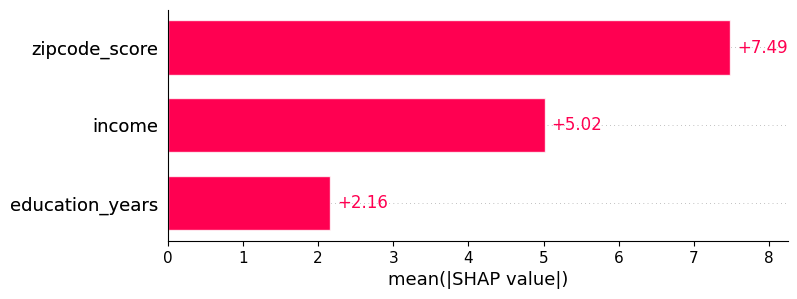

In [11]:
shap.plots.bar(shap_values)

### Import the `group` variable, which was **not** used in training this model.

In [12]:
X_test_with_group = X_test.copy()
X_test_with_group["group"] = df.loc[X_test.index, "group"]

### Look at the difference in SHAP values between the two groups across the variables used in the model.

In [13]:
shap_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
shap_df["group"] = X_test_with_group["group"].values

shap_df.groupby("group").mean()

,income,education_years,zipcode_score
group,,,
0,1.086254,-0.170779,5.866534
1,1.020094,-0.192841,-6.859435


### Let's put `group` and `zipcode_score` in the same plot

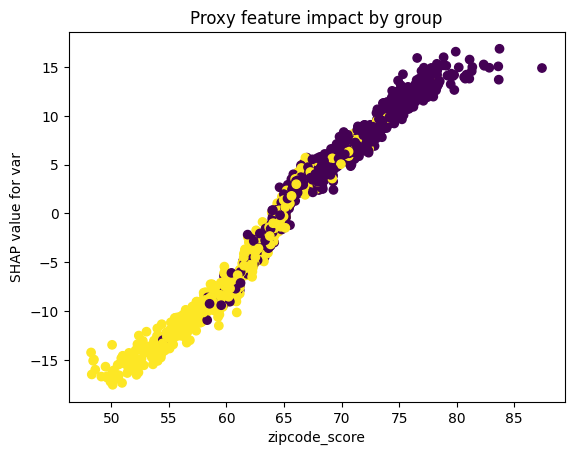

In [14]:
def plot_shap(var):
    # Extract SHAP values for the feature
    shap_var = shap_values[:, var].values

    # Plot the values of each group using different colors
    plt.figure()
    plt.scatter(
        X_test[var],
        shap_var,
        c=X_test_with_group["group"]
    )
    plt.xlabel(var)
    plt.ylabel(f"SHAP value for var")
    plt.title("Proxy feature impact by group")
    plt.show()

plot_shap("zipcode_score")

# Discussion Questions

### What is a _SHAP_ (or Shapley) value? 

For a random forest, a SHAP value determines how much each value conributes to the random forest. The value zipcode helps determine outcomes more than education_years. 

### Suppose you built this model and then it is peer reviewed by another entity. If the reviewer asks whether you used the variable `group` in your model, what would your answer be?

I would state that the group variable was not used in the model since we never trained the model with it, rather it helps us compare the groups on the basis of other variables. Other proxy variables are highly correlated to group, meaning we could use those proxy variables to draw conclusions about groups.

### If the reviewer asks whether the outcome of your model is correlated with `group`, what would your answer be?

Yes since although we did not use the group variable, other variables in the model were strongly correlated to it. This means we can get a rough estimate of the groups influence on the model.

### Construct a "proxy feature impact by group" plot for `income`. How is this plot different from the one for `zipcode_score`?

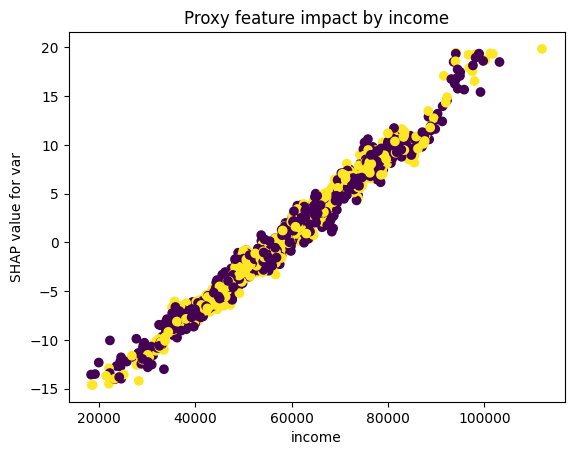

In [16]:
def plot_shap(var):
    # Extract SHAP values for the feature
    shap_var = shap_values[:, var].values

    # Plot the values of each group using different colors
    plt.figure()
    plt.scatter(
        X_test[var],
        shap_var,
        c=X_test_with_group["group"]
    )
    plt.xlabel(var)
    plt.ylabel(f"SHAP value for var")
    plt.title("Proxy feature impact by income")
    plt.show()

plot_shap("income")

The straight line with many and purple lines together showcases how the groups and income are not well seperated. They are very mixed, meaning income is not as correlated with groups. The zipcode variable had groups and zipcode very seperated.

### If, instead, you were the **reviewer**, what other questions might you ask the person who built this model? Give at least two.

1) What was this sample data taken from? Different populations may yield different models and correlations.

2) How to do other types of models fare, do they yield different SHAP values?